In [1]:

import sys

import matplotlib.pyplot as plt
import pandas as pd
import torch

from data_factory.DataLoader import DataLoader
from utils.config import load_config
# evaluation file
from utils.evaluation import label_evaluation

# models

sys.path.append('/media/cyprien/Data/Documents/Github/pytorch-forecasting')



In [2]:
config_file = "../config/config.yml"
config = load_config(config_file)

result_file = '../predict.csv'
truth_file = '../ground_truth.hdf'

In [3]:
dl = DataLoader(use_previous_files=False, config_file=config_file)

INFO:data_factory.DataLoader:../data/train.csv loaded. shape (2476315, 4)
INFO:data_factory.DataLoader:../data/test.csv loaded. shape (2345211, 3)
DEBUG:data_factory.preprocessing:Fill grp 02e99bd4f6cfb33f. shape: (128562, 6)
DEBUG:data_factory.preprocessing:Fill grp 02e99bd4f6cfb33f Done. shape: (131795, 5)
DEBUG:data_factory.preprocessing:Fill grp 046ec29ddf80d62e. shape: (8784, 6)
DEBUG:data_factory.preprocessing:Fill grp 046ec29ddf80d62e Done. shape: (43916, 5)
DEBUG:data_factory.preprocessing:Fill grp 07927a9a18fa19ae. shape: (10960, 6)
DEBUG:data_factory.preprocessing:Fill grp 07927a9a18fa19ae Done. shape: (61471, 5)
DEBUG:data_factory.preprocessing:Fill grp 09513ae3e75778a3. shape: (128971, 6)
DEBUG:data_factory.preprocessing:Fill grp 09513ae3e75778a3 Done. shape: (131785, 5)
DEBUG:data_factory.preprocessing:Fill grp 18fbb1d5a5dc099d. shape: (129128, 6)
DEBUG:data_factory.preprocessing:Fill grp 18fbb1d5a5dc099d Done. shape: (131795, 5)
DEBUG:data_factory.preprocessing:Fill grp 1

## Feature Engineering

In [4]:
normal_train = dl.train[dl.train.label == 0].drop(labels='label', axis=1)
normal_train.shape

(2735180, 34)

In [5]:
from data_factory.preprocessing import *

normal_train = fill_missing_dates(
    normal_train, date_col="datetime", timestamp_col="timestamp", grp_col="kpi_id"
).copy()
normal_train['timestamp_1'] = (normal_train.timestamp / 60).astype(int)
normal_train.authentic = normal_train.authentic.astype(str)

DEBUG:data_factory.preprocessing:Fill grp 02e99bd4f6cfb33f. shape: (121245, 34)
DEBUG:data_factory.preprocessing:Fill grp 02e99bd4f6cfb33f Done. shape: (131795, 33)
DEBUG:data_factory.preprocessing:Fill grp 046ec29ddf80d62e. shape: (43836, 34)
DEBUG:data_factory.preprocessing:Fill grp 046ec29ddf80d62e Done. shape: (43916, 33)
DEBUG:data_factory.preprocessing:Fill grp 07927a9a18fa19ae. shape: (61341, 34)
DEBUG:data_factory.preprocessing:Fill grp 07927a9a18fa19ae Done. shape: (61471, 33)
DEBUG:data_factory.preprocessing:Fill grp 09513ae3e75778a3. shape: (131547, 34)
DEBUG:data_factory.preprocessing:Fill grp 09513ae3e75778a3 Done. shape: (131785, 33)
DEBUG:data_factory.preprocessing:Fill grp 18fbb1d5a5dc099d. shape: (123932, 34)
DEBUG:data_factory.preprocessing:Fill grp 18fbb1d5a5dc099d Done. shape: (131795, 33)
DEBUG:data_factory.preprocessing:Fill grp 1c35dbf57f55f5e4. shape: (122214, 34)
DEBUG:data_factory.preprocessing:Fill grp 1c35dbf57f55f5e4 Done. shape: (131795, 33)
DEBUG:data_fac

In [6]:
max_prediction_length = 1
max_encoder_length = config['LinearAutoEncoder']['max_seq_len']
min_encoder_length = config['LinearAutoEncoder']['min_seq_len']


In [7]:
from pytorch_forecasting import TimeSeriesDataSet

kpi_id_ref = normal_train.kpi_id.unique()[0]

X_cols = ['value_scaled', 'kpi_id', 'timestamp_1', 'authentic']
normal_train = normal_train.reset_index(drop=True)

validation_filter = normal_train.groupby('kpi_id').apply(
    lambda x: x.timestamp_1 < (x.timestamp_1.max() - (max_encoder_length + max_prediction_length))).reset_index(
    drop=True)

training = TimeSeriesDataSet(
    normal_train.loc[validation_filter, X_cols],
    time_idx='timestamp_1', target='value_scaled',
    group_ids=['kpi_id'],
    allow_missing_timesteps=False,
    static_categoricals=['kpi_id', 'authentic'],
    time_varying_unknown_reals=['value_scaled'],
    # time_varying_known_reals=['timestamp_1'],
    max_encoder_length=max_encoder_length,
    min_encoder_length=min_encoder_length,
    max_prediction_length=max_prediction_length,
    scalers={col: None for col in ['timestamp_1', 'kpi_id']},
    target_normalizer=None,
    add_relative_time_idx=False,
    add_target_scales=False,
    add_encoder_length=False,
)

validation = TimeSeriesDataSet.from_dataset(
    training, normal_train, stop_randomization=True, predict=True
)
training_annomaly = TimeSeriesDataSet.from_dataset(
    training, dl.train, stop_randomization=True, predict=False, min_encoder_length=max_encoder_length
)
testing = TimeSeriesDataSet.from_dataset(
    training, dl.test, stop_randomization=True, predict=False, min_encoder_length=max_encoder_length
)

In [8]:
batch_size = 64

training_dl = training.to_dataloader(train=True, batch_size=batch_size, num_workers=12)

validation_dl = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=12)
training_annomaly_dl = training_annomaly.to_dataloader(train=False, batch_size=batch_size * 3, num_workers=12)
testing_dl = testing.to_dataloader(train=False, batch_size=batch_size * 3, num_workers=12)


## Model

In [9]:
from models.autoencoder_lightning import LitAE

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)
n_features = 1
n_dim = config['LinearAutoEncoder']['in_features']

Using cuda


In [11]:
# torch.concat([
#     next(iter(training_dl))[0]['encoder_cont'].squeeze(2).moveaxis(1, 0),
#     next(iter(training_dl))[0]['decoder_target'].moveaxis(1, 0)
# ]).moveaxis(1, 0).shape

In [12]:
# torch.manual_seed(42)
# next(iter(training_dl))[0]['encoder_lengths']


In [13]:

# print(torch.concat([
#     next(iter(training_dl))[0]['encoder_cat'].squeeze(2).moveaxis(1, 0),
#     next(iter(training_dl))[0]['decoder_cat'].moveaxis(1, 0)
# ]).moveaxis(1, 0).shape)
#
# # next(iter(training_dl))[0]['encoder_cat'].reshape(-1, 2)[:, 0].min()
# torch.concat([
#     next(iter(training_dl))[0]['encoder_cat'].squeeze(2).moveaxis(1, 0),
#     next(iter(training_dl))[0]['decoder_cat'].moveaxis(1, 0)
# ]).moveaxis(1, 0)[:, :, 1].sum()


In [14]:
# print(torch.concat([
#     next(iter(training_dl))[0]['encoder_cat'].squeeze(2).moveaxis(1, 0),
#     next(iter(training_dl))[0]['decoder_cat'].moveaxis(1, 0)
# ]).moveaxis(1, 0).shape)
#
# print(
#     next(iter(training_dl))[0]['encoder_cat'].squeeze(2).shape)


In [15]:

from tqdm import tqdm

# model = LitAE(input_shape=max_encoder_length, n_dim=n_dim)
model = LitAE.load_from_checkpoint("./lightning_logs/version_1/checkpoints/epoch=4-step=171145.ckpt",
                                   input_shape=max_encoder_length, n_dim=n_dim)


INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpp88go4w6
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpp88go4w6/_remote_module_non_sriptable.py


In [16]:

from pytorch_lightning.trainer import Trainer

trainer = Trainer(logger=True, enable_checkpointing=True, checkpoint_callback=None, gpus=1, auto_lr_find=True,
                  max_epochs=-1)

trainer.validate(model=model, dataloaders=validation_dl)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss               132982.40625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:72: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 26. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


[{'val_loss': 132982.40625}]

In [17]:
trainer.fit(model=model, train_dataloaders=training_dl, val_dataloaders=validation_dl)

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                 | Type   | Params
------------------------------------------------
0 | encoder_hidden_layer | Linear | 6.1 M 
1 | encoder_output_layer | Linear | 65.8 K
2 | decoder_hidden_layer | Linear | 65.8 K
3 | decoder_output_layer | Linear | 6.2 M 
------------------------------------------------
12.4 M    Trainable params
0         Non-trainable params
12.4 M    Total params
49.775    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:724: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [29]:
trainer.validate(model=model, dataloaders=validation_dl)

# trainer.test(model)
# trainer.predict(model)

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss              128391.5078125
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 128391.5078125}]

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss              128391.5078125
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 128391.5078125}]

## Predict abnormal value

In [30]:
def predict(df: pd.DataFrame):
    df['timestamp_1_floor'] = df.groupby('kpi_id').timestamp_1.transform(lambda x: x - x.min())
    pv = pd.pivot_table(df, values='value_scaled', index='timestamp_1_floor', columns='kpi_id', fill_value=np.nan)

    ept = np.empty(max_encoder_length)
    ept[:] = np.nan

    pv = pd.concat([pv, pd.DataFrame({col: ept.copy() for col in pv.columns})])

    pv_forward = np.moveaxis(pv.copy().to_numpy(dtype=np.float32), 1, 0)
    pv_filter = np.moveaxis(pv.copy().to_numpy(), 1, 0)
    pv_forward[np.isnan(pv_forward)] = 0
    pv_filter = np.where(np.isnan(pv_filter), 0, 1)

    df['value_pred'] = np.nan

    for i in tqdm(np.arange(0, pv.index.max() + 1, max_encoder_length)):
        pv_forward_i = pv_forward[:, i:i + max_encoder_length]
        pv_filter_i = pv_filter[:, i:i + max_encoder_length]

        X = torch.from_numpy(pv_forward_i.copy())

        y_pred = model(X)

        validation_filter = df.groupby('kpi_id').apply(
            lambda x: (x.timestamp_1_floor >= i) & (x.timestamp_1_floor < i + max_encoder_length)).reset_index(
            drop=True)

        df.loc[validation_filter, 'value_pred'] = y_pred.cpu().detach().numpy()[pv_filter_i.astype(bool)].flatten()

    df['label_pred'] = np.nan

    for kpi_id in df.kpi_id.unique():
        THRESHOLD = np.abs(
            df[(df.kpi_id == kpi_id)].value_pred - df[(df.kpi_id == kpi_id)].value_scaled).quantile(
            .995)
        df.loc[(df.kpi_id == kpi_id), 'label_pred'] = np.abs(
            df[(df.kpi_id == kpi_id)].value_pred -
            df[(df.kpi_id == kpi_id)].value_scaled) > THRESHOLD


predict(dl.train)
predict(dl.test)


100%|██████████| 7/7 [00:06<00:00,  1.11it/s]

100%|██████████| 7/7 [00:06<00:00,  1.16it/s]

100%|██████████| 7/7 [00:08<00:00,  1.15s/it]

100%|██████████| 7/7 [00:06<00:00,  1.12it/s]


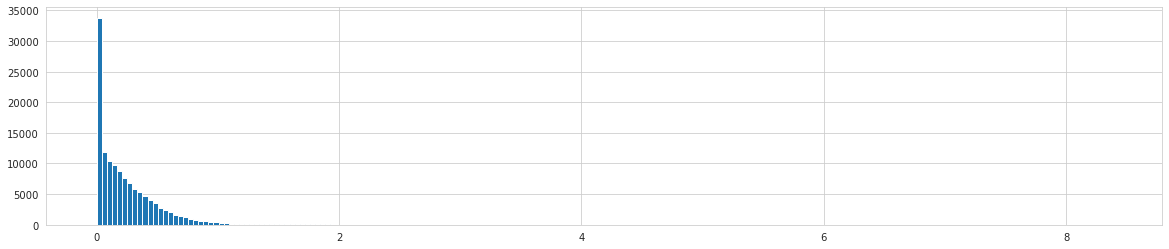

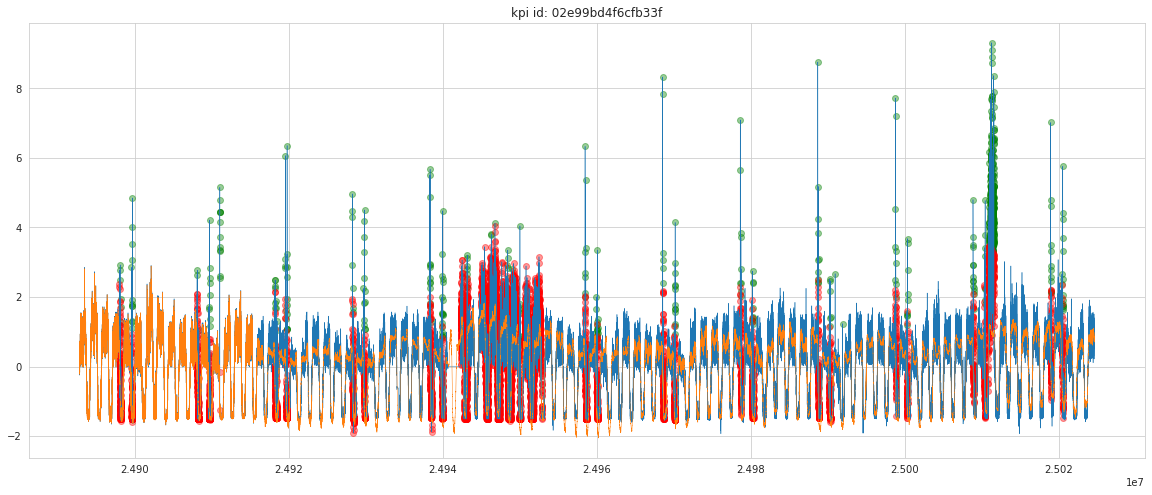

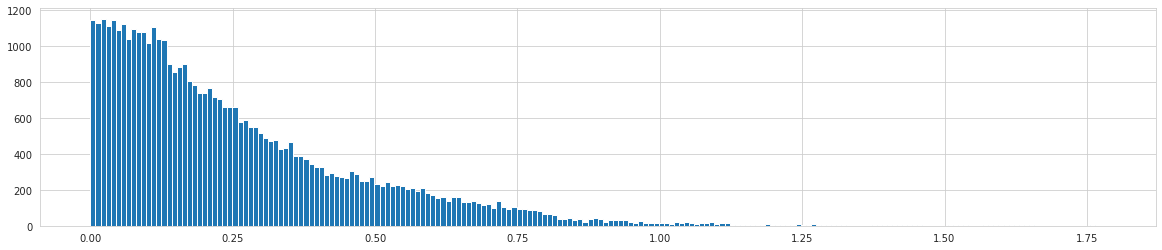

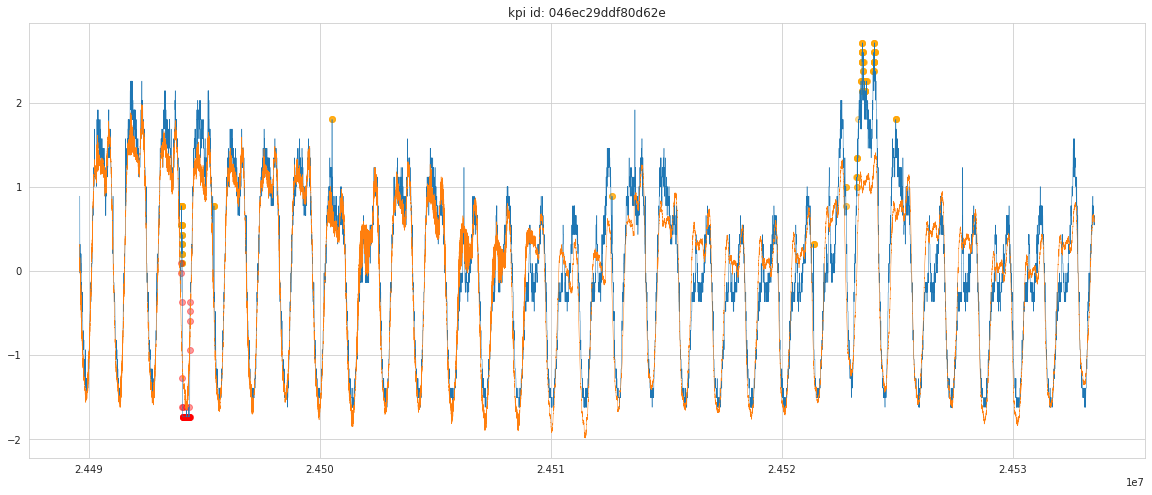

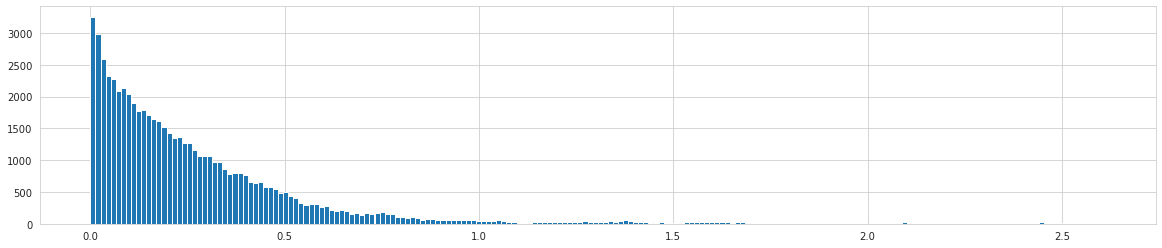

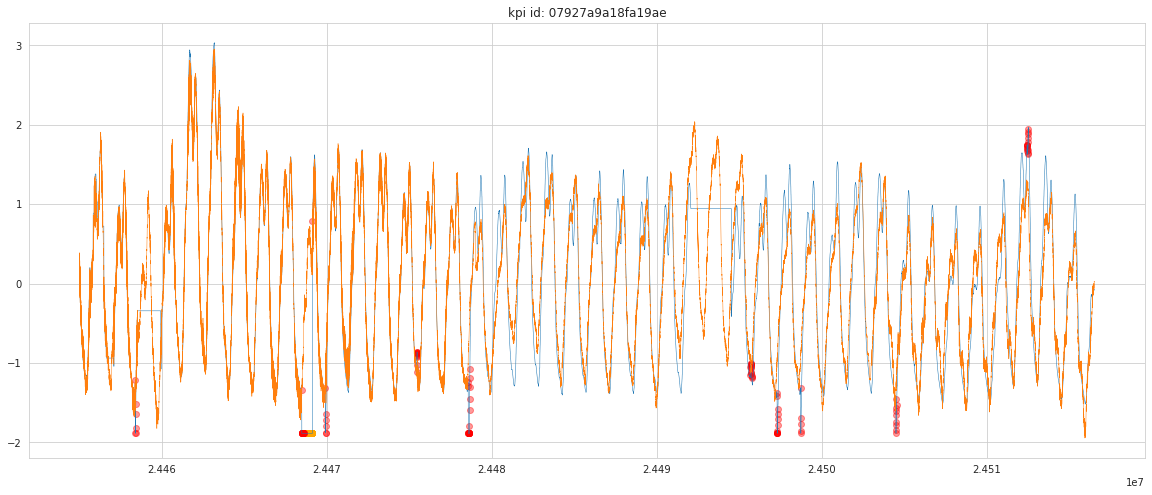

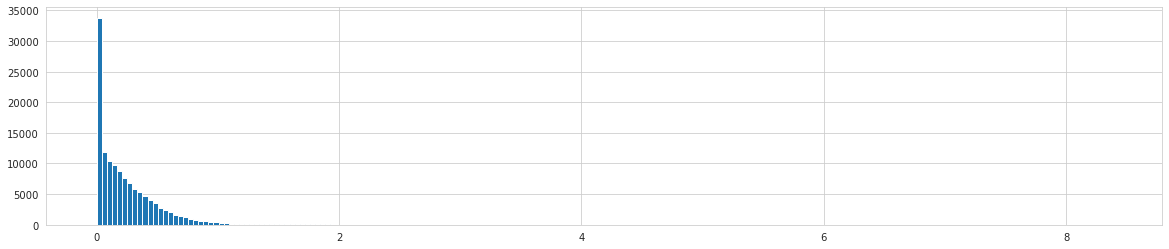

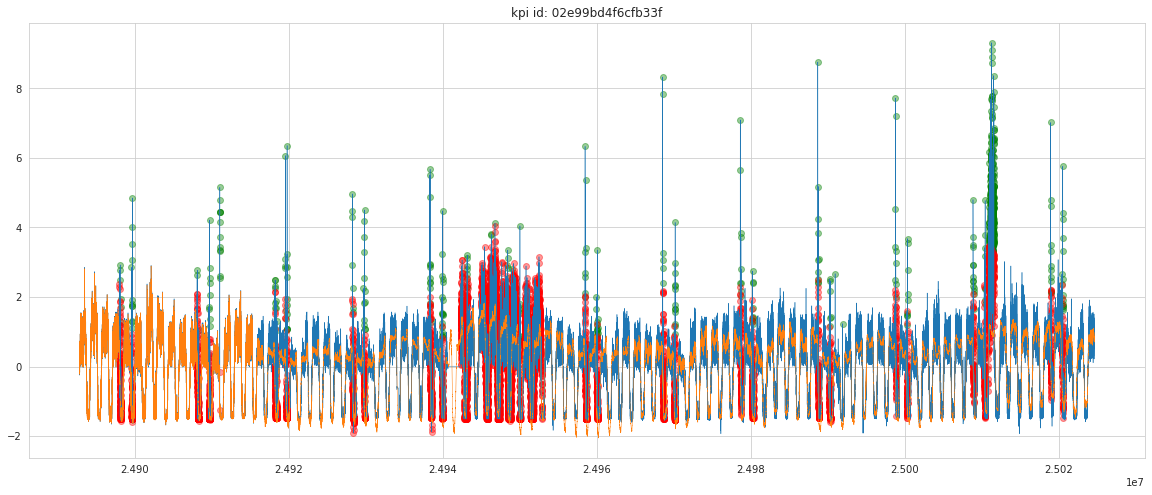

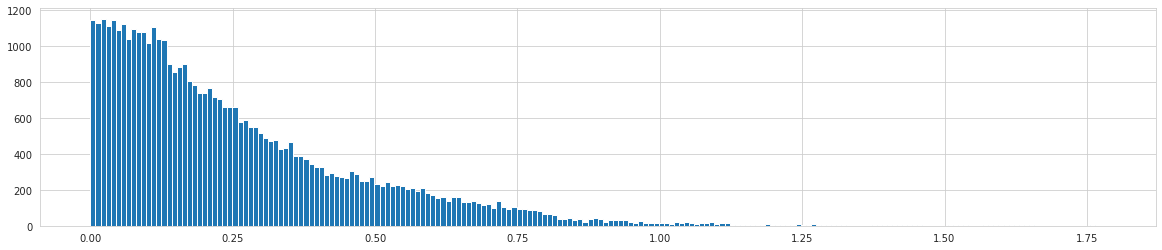

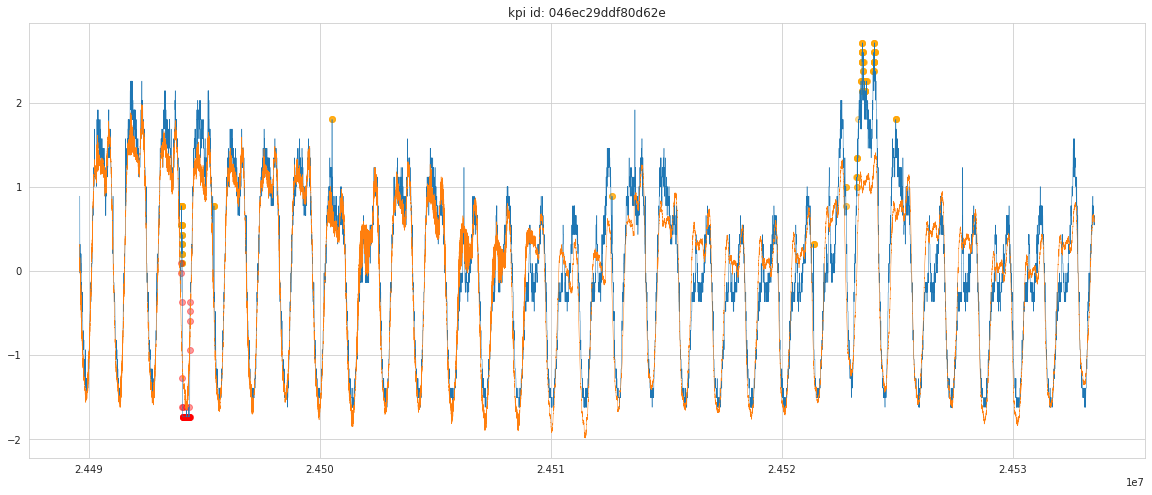

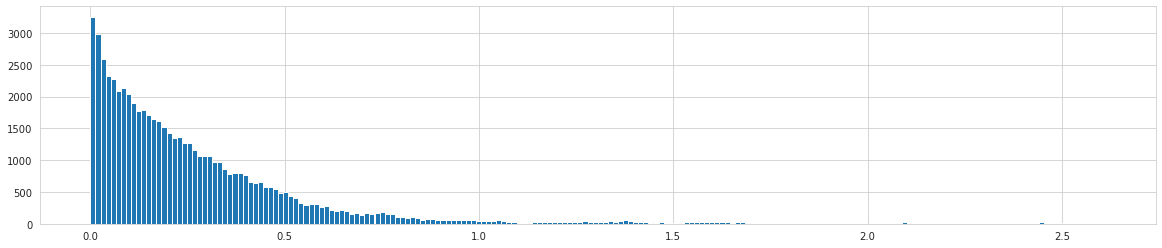

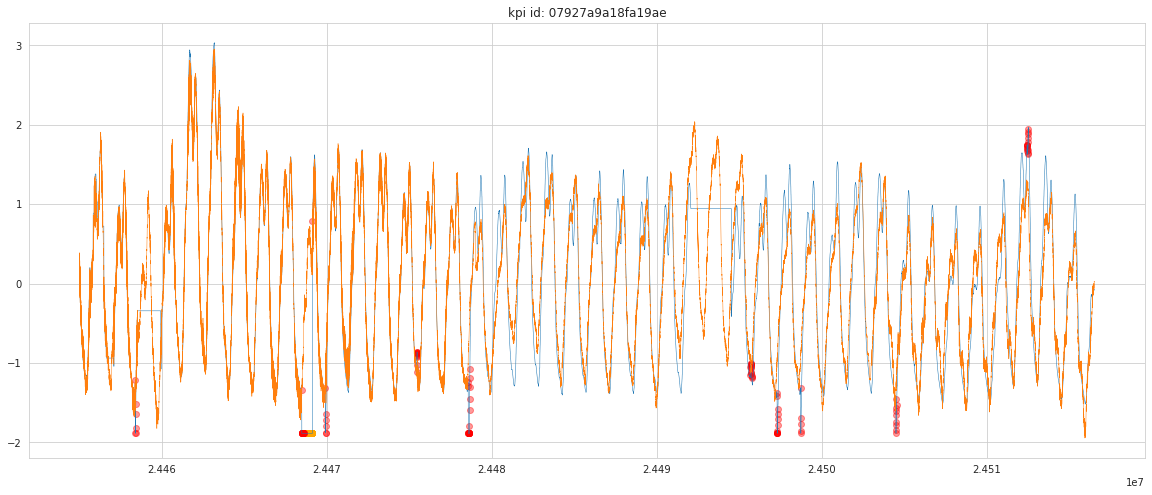

In [33]:
import logging
from logging import WARNING

logging.basicConfig(level=WARNING)

for kpi_id in dl.train.kpi_id.unique()[:3]:
    df = dl.train[(dl.train.kpi_id == kpi_id)]

    figure = plt.figure(figsize=(20, 4))
    plt.hist(np.abs(df.value_pred - df.value_scaled), bins=200, figure=figure)

    true_positive = ((df.label == 1) & (df.label_pred == 1))
    false_positive = ((df.label == 0) & (df.label_pred == 1))
    false_negative = ((df.label == 1) & (df.label_pred == 0))

    figure = plt.figure(figsize=(20, 8))
    for filter, color in zip([true_positive, false_positive, false_negative], ['g', 'orange', 'r']):
        plt.scatter(df[filter].timestamp_1, df[filter].value_scaled, c=color, alpha=.4)

    plt.plot(df.timestamp_1, df.value_scaled, figure=figure, linewidth=.5)
    plt.plot(df.timestamp_1, df.value_pred, figure=figure, linewidth=.5)
    plt.title(f'kpi id: {kpi_id}')
    plt.show()

## Export

In [36]:
validation_start_points = normal_train.groupby('kpi_id').apply(
    lambda x: x.timestamp_1.max() - (max_encoder_length + max_prediction_length)).to_frame('limit').to_dict()['limit']
validation_start_points

{'02e99bd4f6cfb33f': 25000593,
 '046ec29ddf80d62e': 24509514,
 '07927a9a18fa19ae': 24492509,
 '09513ae3e75778a3': 25000583,
 '18fbb1d5a5dc099d': 25000593,
 '1c35dbf57f55f5e4': 25000593,
 '40e25005ff8992bd': 25016779,
 '54e8a140f6237526': 24504224,
 '71595dd7171f4540': 24977755,
 '769894baefea4e9e': 24646314,
 '76f4550c43334374': 24647754,
 '7c189dd36f048a6c': 24977746,
 '88cf3a776ba00e7c': 24924220,
 '8a20c229e9860d0c': 24640554,
 '8bef9af9a922e0b3': 24958686,
 '8c892e5525f3e491': 24978451,
 '9bd90500bfd11edb': 25000593,
 '9ee5879409dccef9': 24924265,
 'a40b1df87e3f1c87': 24967498,
 'a5bf5d65261d859a': 25000588,
 'affb01ca2b4f0b45': 24977727,
 'b3b2e6d1a791d63a': 24504219,
 'c58bfcbacb2822d1': 25000588,
 'cff6d3c01e6a6bfa': 24977797,
 'da403e4e3f87c9e0': 25000588,
 'e0770391decc44ce': 24978437}

In [37]:
validation_filter = dl.train.groupby('kpi_id').apply(
    lambda x: x.timestamp_1 >= validation_start_points[x.kpi_id.iloc[0]]).reset_index(
    drop=True)

In [38]:
prediction = dl.train.loc[validation_filter  & (dl.train.authentic == 'True'), ['timestamp', 'kpi_id', 'label_pred']].rename(columns={'kpi_id': 'KPI ID'})
prediction['predict'] = prediction['label_pred']
prediction.to_csv(result_file)

ground_truth = dl.train.loc[validation_filter & (dl.train.authentic == 'True'), ['timestamp', 'kpi_id', 'label']].rename(columns={'kpi_id': 'KPI ID'})
ground_truth.to_hdf(truth_file, key='df')

print(label_evaluation(truth_file, result_file))

{"result": true, "data": 0.24708147791551333, "message": "计算成功"}


In [39]:
prediction = dl.train.loc[~validation_filter & (dl.train.authentic == 'True'), ['timestamp', 'kpi_id', 'label_pred']].rename(columns={'kpi_id': 'KPI ID'})
prediction['predict'] = prediction['label_pred']
prediction.to_csv(result_file)

ground_truth = dl.train.loc[~validation_filter & (dl.train.authentic == 'True'), ['timestamp', 'kpi_id', 'label']].rename(columns={'kpi_id': 'KPI ID'})
ground_truth.to_hdf(truth_file, key='df')

print(label_evaluation(truth_file, result_file))

{"result": true, "data": 0.24661342103202566, "message": "计算成功"}


In [40]:
prediction = dl.test.loc[dl.test.authentic == 'True', ['timestamp', 'kpi_id', 'label_pred']].rename(columns={'kpi_id': 'KPI ID'})
prediction['predict'] = prediction['label_pred'].astype(int)
prediction.drop(columns=['label_pred'], inplace=True)
prediction.to_csv(result_file)

### Plot

In [41]:
prediction.predict.sum()

11923

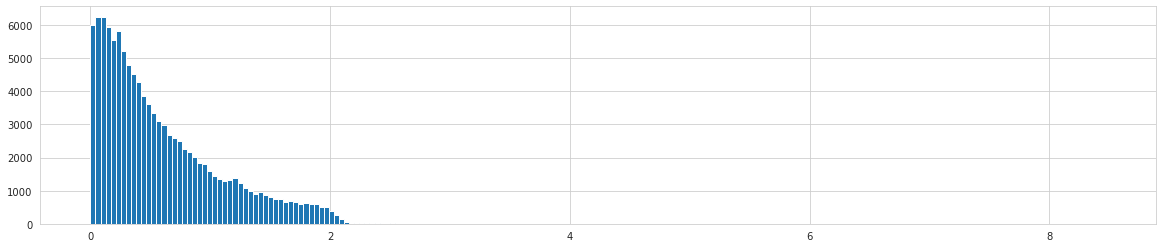

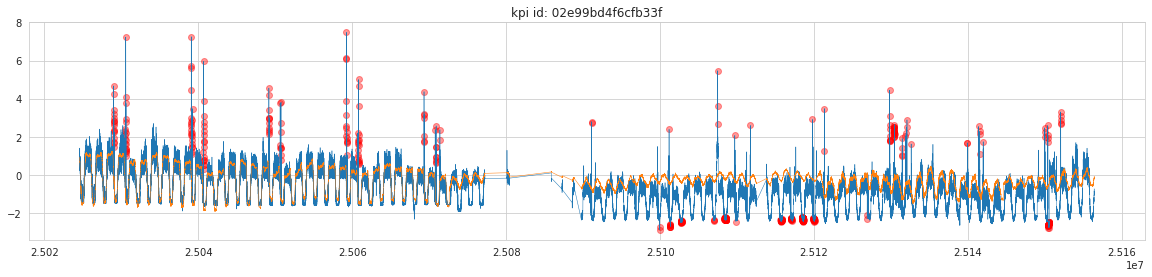

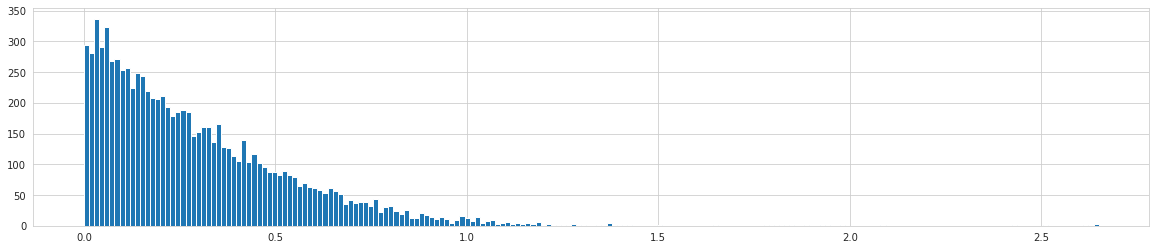

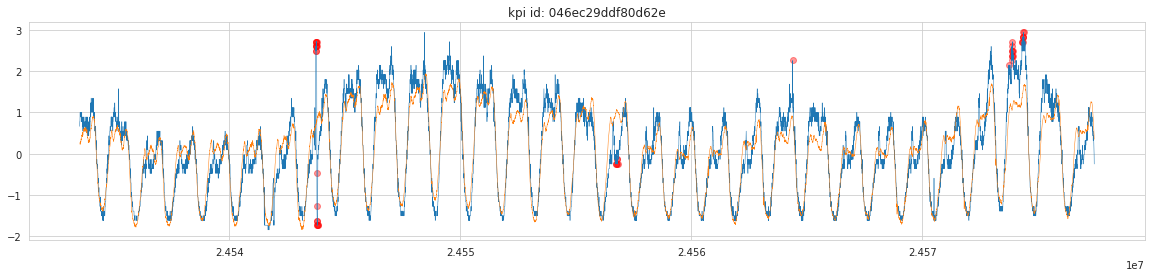

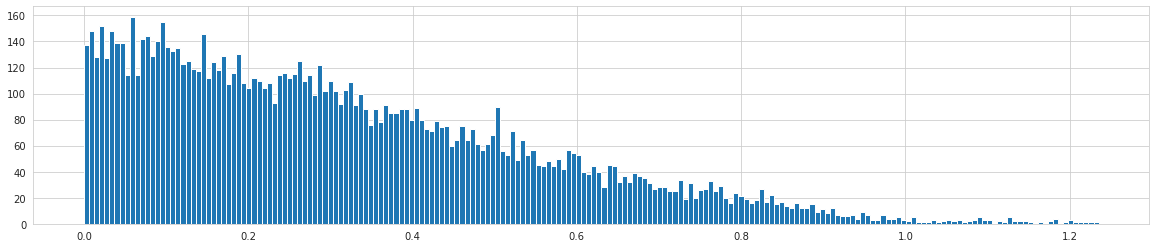

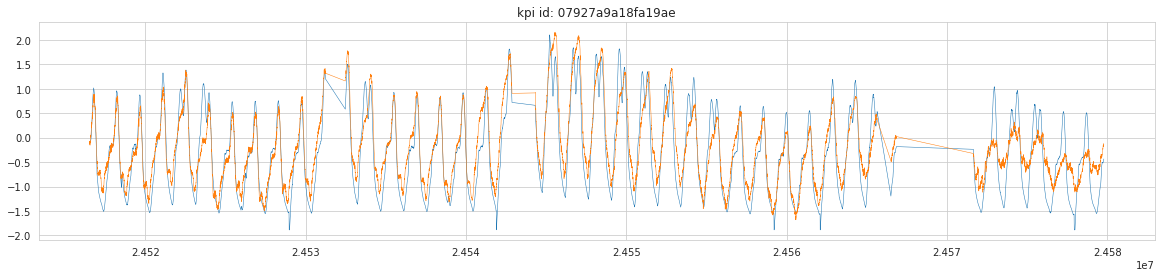

In [42]:
import logging
from logging import WARNING

logging.basicConfig(level=WARNING)

for kpi_id in dl.test.kpi_id.unique()[:3]:
    df = dl.test[(dl.test.kpi_id == kpi_id) & (dl.test.authentic == 'True')]

    figure = plt.figure(figsize=(20, 4))
    plt.hist(np.abs(df.value_pred - df.value_scaled), bins=200, figure=figure)
    plt.show()

    figure = plt.figure(figsize=(20, 4))

    plt.scatter(df[df.label_pred == 1].timestamp_1, df[df.label_pred == 1].value_scaled, c='r', alpha=.4)

    plt.plot(df.timestamp_1, df.value_scaled, figure=figure, linewidth=.5)
    plt.plot(df.timestamp_1, df.value_pred, figure=figure, linewidth=.5)
    plt.title(f'kpi id: {kpi_id}')
    plt.show()